# 🎵 Prédiction de Churn - Service de Streaming Musical

---

## Objectif

Prédire si un utilisateur va **churner** (résilier son abonnement) dans les **10 jours** suivant le 2018-11-20.

Un utilisateur est considéré comme ayant churné s'il visite la page `'Cancellation Confirmation'`.

---

## Plan du notebook

1. **Chargement et exploration des données**
2. **Nettoyage et préparation**
3. **Feature Engineering**
4. **Analyse exploratoire**
5. **Modélisation**
6. **Évaluation et comparaison**
7. **Analyse des features importantes**
8. **Prédiction sur données de test**

## 1. Imports et Configuration

In [1]:
# Manipulation de données
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, f1_score
)

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Couleurs personnalisées
COLORS = {
    'primary': '#3498db',
    'success': '#2ecc71',
    'danger': '#e74c3c',
    'warning': '#f39c12',
    'purple': '#9b59b6'
}

print("✅ Imports chargés avec succès!")

✅ Imports chargés avec succès!


## 2. Chargement des Données

In [2]:
# Charger les données
df = pd.read_csv('df_train_sample.csv')

print(f"📊 Dimensions du dataset: {df.shape[0]:,} événements, {df.shape[1]} colonnes")
print(f"👥 Nombre d'utilisateurs uniques: {df['userId'].nunique():,}")

📊 Dimensions du dataset: 87,945 événements, 20 colonnes
👥 Nombre d'utilisateurs uniques: 14,847


In [3]:
# Aperçu des premières lignes
df.head(10)

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration,will_churn_10days
0,200,M,Mario,paid,Lucas,1590986,1540384853000,Logged In,NextSong,111959,"New York-Newark-Jersey City, NY-NJ-PA",148,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,340.45342,What It Was_ Was Football (Part 1 And 2) (Digi...,Andy Griffith,2018-10-24 12:40:53,2018-08-31 19:53:59,0
1,200,F,Angel,paid,Morris,1833605,1539035076000,Logged In,NextSong,56997,"Boston-Cambridge-Newton, MA-NH",58,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,219.76771,Knights,Minus The Bear,2018-10-08 21:44:36,2018-09-06 17:54:14,0
2,200,M,Lucas,paid,Beasley,1198970,1541443982000,Logged In,NextSong,152868,"Champaign-Urbana, IL",141,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,239.51628,Niki Fm (Album Version),Hawthorne Heights,2018-11-05 18:53:02,2018-09-03 06:04:33,0
3,200,M,Lucas,paid,Peterson,1143843,1541263818000,Logged In,NextSong,150559,"San Francisco-Oakland-Hayward, CA",87,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,170.42240,Secret Curse,Dismemberment Plan,2018-11-03 16:50:18,2018-08-27 19:51:31,0
4,200,F,Zaliyah,paid,King,1403205,1539175857000,Logged In,NextSong,63420,"Washington-Arlington-Alexandria, DC-VA-MD-WV",31,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,213.62893,Reach For The Sky (Album),Social Distortion,2018-10-10 12:50:57,2018-08-15 06:11:02,0
5,200,F,Piper,free,Olson,1725754,1541254835000,Logged In,NextSong,22649,"Salt Lake City, UT",2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,47.30730,Look Inside,Gustavo Santaolalla,2018-11-03 14:20:35,2018-09-15 01:50:58,0
6,200,F,Marlene,free,Waters,1488221,1538490026000,Logged In,Home,5447,"Birmingham-Hoover, AL",8,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",GET,NaN,NaN,NaN,2018-10-02 14:20:26,2018-08-29 11:15:12,0
7,200,M,Ryder,paid,Allen,1237889,1540747798000,Logged In,NextSong,74554,"Chicago-Naperville-Elgin, IL-IN-WI",38,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,235.85914,The World Is Not Enough,Garbage,2018-10-28 17:29:58,2018-09-13 18:31:47,0
8,200,M,Clayton,paid,Richardson,1777114,1540431162000,Logged In,NextSong,116002,"Lancaster, PA",335,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",PUT,198.03383,Too Young,Phoenix,2018-10-25 01:32:42,2018-08-23 05:03:57,0
9,200,F,Libby,free,Weaver,1520578,1540672448000,Logged In,Add to Playlist,128850,"Wichita, KS",30,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",PUT,NaN,NaN,NaN,2018-10-27 20:34:08,2018-08-30 02:20:54,0


In [4]:
# Informations sur les colonnes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87945 entries, 0 to 87944
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             87945 non-null  int64  
 1   gender             87945 non-null  object 
 2   firstName          87945 non-null  object 
 3   level              87945 non-null  object 
 4   lastName           87945 non-null  object 
 5   userId             87945 non-null  int64  
 6   ts                 87945 non-null  int64  
 7   auth               87945 non-null  object 
 8   page               87945 non-null  object 
 9   sessionId          87945 non-null  int64  
 10  location           87945 non-null  object 
 11  itemInSession      87945 non-null  int64  
 12  userAgent          87945 non-null  object 
 13  method             87945 non-null  object 
 14  length             71811 non-null  float64
 15  song               71811 non-null  object 
 16  artist             718

In [5]:
# Statistiques descriptives
df.describe()

,status,userId,ts,sessionId,itemInSession,length,will_churn_10days
count,87945.000000,8.794500e+04,8.794500e+04,87945.000000,87945.000000,71811.000000,87945.000000
mean,209.041628,1.491457e+06,1.540074e+12,72921.964728,104.856672,249.162625,0.122918
std,30.024386,2.891965e+05,1.021776e+09,52983.420029,117.570197,98.088448,0.328345
min,200.000000,1.000025e+06,1.538352e+12,3.000000,0.000000,1.122810,0.000000
25%,200.000000,1.237277e+06,1.539189e+12,21367.000000,25.000000,200.319550,0.000000
50%,200.000000,1.491974e+06,1.540027e+12,67633.000000,65.000000,234.135060,0.000000
75%,200.000000,1.737350e+06,1.540941e+12,119165.000000,142.000000,277.158730,0.000000
max,404.000000,1.999905e+06,1.542672e+12,203914.000000,1285.000000,3024.665670,1.000000


## 3. Nettoyage et Préparation

In [6]:
# Conversion des timestamps
df['time'] = pd.to_datetime(df['time'])
df['registration'] = pd.to_datetime(df['registration'])

# Date de référence (fin de la période d'observation)
REFERENCE_DATE = pd.to_datetime('2018-11-20')

print(f"📅 Période des données: du {df['time'].min()} au {df['time'].max()}")
print(f"📅 Date de référence: {REFERENCE_DATE}")

📅 Période des données: du 2018-10-01 00:02:13 au 2018-11-19 23:54:05
📅 Date de référence: 2018-11-20 00:00:00


In [7]:
# Vérification des valeurs manquantes
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Manquants': missing, 'Pourcentage (%)': missing_pct})
missing_df[missing_df['Manquants'] > 0]

,Manquants,Pourcentage (%)
length,16134,18.35
song,16134,18.35
artist,16134,18.35


In [8]:
# Distribution de la variable cible
churn_by_user = df.groupby('userId')['will_churn_10days'].first()
churn_counts = churn_by_user.value_counts()

print("🎯 Distribution de la variable cible (par utilisateur):")
print(f"   Non-Churn (0): {churn_counts[0]:,} ({churn_counts[0]/len(churn_by_user)*100:.2f}%)")
print(f"   Churn (1):     {churn_counts[1]:,} ({churn_counts[1]/len(churn_by_user)*100:.2f}%)")

🎯 Distribution de la variable cible (par utilisateur):
   Non-Churn (0): 12,752 (85.89%)
   Churn (1):     2,095 (14.11%)


In [9]:
# Types de pages visitées
print("📄 Types de pages visitées:")
df['page'].value_counts()

📄 Types de pages visitées:


page
NextSong                     71811
Thumbs Up                     3910
Home                          3194
Add to Playlist               2028
Roll Advert                   1506
Add Friend                    1368
Logout                        1017
Thumbs Down                    802
Downgrade                      644
Settings                       531
Help                           420
Upgrade                        224
About                          191
Save Settings                   91
Error                           70
Submit Upgrade                  60
Cancellation Confirmation       28
Cancel                          26
Submit Downgrade                24
Name: count, dtype: int64

## 4. Feature Engineering

Nous allons créer des **features agrégées au niveau utilisateur** à partir des événements.

In [10]:
def create_user_features(df, reference_date):
    """
    Crée des features agrégées au niveau utilisateur.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame contenant les événements utilisateur
    reference_date : datetime
        Date de référence pour le calcul des features temporelles
    
    Returns:
    --------
    DataFrame avec une ligne par utilisateur et les features calculées
    """
    
    # Filtrer les événements avant la date de référence
    df_filtered = df[df['time'] <= reference_date].copy()
    
    # DataFrame pour stocker les features
    user_features = pd.DataFrame()
    user_features['userId'] = df_filtered['userId'].unique()
    
    # =========================================================================
    # FEATURES DÉMOGRAPHIQUES
    # =========================================================================
    user_info = df_filtered.groupby('userId').agg({
        'gender': 'first',
        'level': 'last',  # Dernier niveau connu
        'registration': 'first',
        'will_churn_10days': 'first'
    }).reset_index()
    
    user_features = user_features.merge(user_info, on='userId', how='left')
    
    # Ancienneté (jours depuis inscription)
    user_features['days_since_registration'] = (
        reference_date - user_features['registration']
    ).dt.days
    
    # =========================================================================
    # FEATURES D'ACTIVITÉ GLOBALE
    # =========================================================================
    activity = df_filtered.groupby('userId').agg({
        'ts': 'count',  # Nombre total d'événements
        'sessionId': 'nunique',  # Nombre de sessions uniques
        'time': ['min', 'max'],  # Première et dernière activité
        'length': ['sum', 'mean', 'count'],  # Durée d'écoute
    })
    activity.columns = ['_'.join(col).strip() for col in activity.columns]
    activity = activity.reset_index()
    activity.columns = ['userId', 'total_events', 'unique_sessions', 
                        'first_activity', 'last_activity',
                        'total_listening_time', 'avg_song_length', 'songs_with_length']
    
    user_features = user_features.merge(activity, on='userId', how='left')
    
    # Récence (jours depuis la dernière activité)
    user_features['days_since_last_activity'] = (
        reference_date - pd.to_datetime(user_features['last_activity'])
    ).dt.days
    
    # Durée d'activité (jours entre première et dernière activité)
    user_features['activity_span_days'] = (
        pd.to_datetime(user_features['last_activity']) - 
        pd.to_datetime(user_features['first_activity'])
    ).dt.days + 1
    
    # Fréquence d'utilisation
    user_features['events_per_day'] = (
        user_features['total_events'] / user_features['activity_span_days']
    ).replace([np.inf, -np.inf], 0)
    
    user_features['sessions_per_day'] = (
        user_features['unique_sessions'] / user_features['activity_span_days']
    ).replace([np.inf, -np.inf], 0)
    
    # =========================================================================
    # FEATURES PAR TYPE DE PAGE
    # =========================================================================
    important_pages = [
        'NextSong', 'Home', 'Thumbs Up', 'Thumbs Down', 
        'Add to Playlist', 'Add Friend', 'Roll Advert',
        'Downgrade', 'Cancel', 'Submit Downgrade', 'Error',
        'Help', 'Settings', 'Logout', 'Upgrade', 'Submit Upgrade'
    ]
    
    page_counts = df_filtered.groupby(['userId', 'page']).size().unstack(fill_value=0)
    
    for page in important_pages:
        col_name = f'page_{page.lower().replace(" ", "_")}'
        if page in page_counts.columns:
            page_counts_temp = page_counts[[page]].reset_index()
            page_counts_temp.columns = ['userId', col_name]
            user_features = user_features.merge(page_counts_temp, on='userId', how='left')
            user_features[col_name] = user_features[col_name].fillna(0)
        else:
            user_features[col_name] = 0
    
    # =========================================================================
    # FEATURES DE SIGNAUX DE CHURN
    # =========================================================================
    # Visites sur pages de résiliation/downgrade
    user_features['churn_signals'] = (
        user_features.get('page_downgrade', 0) + 
        user_features.get('page_cancel', 0) + 
        user_features.get('page_submit_downgrade', 0)
    )
    
    # Ratio Thumbs Down / Thumbs Up
    user_features['thumbs_ratio'] = (
        user_features.get('page_thumbs_down', 0) / 
        (user_features.get('page_thumbs_up', 0) + 1)
    )
    
    # Taux d'erreurs
    user_features['error_rate'] = (
        user_features.get('page_error', 0) / user_features['total_events']
    ).fillna(0)
    
    # =========================================================================
    # FEATURES D'ENGAGEMENT
    # =========================================================================
    # Ratio de chansons écoutées sur total d'événements
    user_features['song_event_ratio'] = (
        user_features.get('page_nextsong', 0) / user_features['total_events']
    ).fillna(0)
    
    # Interactions positives (Thumbs Up + Add to Playlist + Add Friend)
    user_features['positive_interactions'] = (
        user_features.get('page_thumbs_up', 0) + 
        user_features.get('page_add_to_playlist', 0) + 
        user_features.get('page_add_friend', 0)
    )
    
    # Taux d'interactions positives
    user_features['positive_interaction_rate'] = (
        user_features['positive_interactions'] / user_features['total_events']
    ).fillna(0)
    
    # =========================================================================
    # FEATURES TEMPORELLES
    # =========================================================================
    # Dernière semaine vs reste de la période
    one_week_before = reference_date - pd.Timedelta(days=7)
    
    last_week = df_filtered[df_filtered['time'] >= one_week_before].groupby('userId').size()
    last_week = last_week.reset_index()
    last_week.columns = ['userId', 'events_last_week']
    
    user_features = user_features.merge(last_week, on='userId', how='left')
    user_features['events_last_week'] = user_features['events_last_week'].fillna(0)
    
    # Tendance d'activité (activité récente vs ancienne)
    user_features['activity_trend'] = (
        user_features['events_last_week'] / (user_features['total_events'] + 1)
    )
    
    # =========================================================================
    # FEATURES PAR NIVEAU (paid/free)
    # =========================================================================
    # Historique des changements de niveau
    level_changes = df_filtered.groupby('userId')['level'].nunique().reset_index()
    level_changes.columns = ['userId', 'level_changes']
    user_features = user_features.merge(level_changes, on='userId', how='left')
    user_features['has_changed_level'] = (user_features['level_changes'] > 1).astype(int)
    
    return user_features

In [11]:
# Création des features
print("⚙️ Création des features utilisateur...")
user_df = create_user_features(df, REFERENCE_DATE)

print(f"✅ Dataset agrégé: {user_df.shape[0]:,} utilisateurs, {user_df.shape[1]} colonnes")

⚙️ Création des features utilisateur...
✅ Dataset agrégé: 14,847 utilisateurs, 43 colonnes


In [37]:
user_df

,userId,gender,level,registration,will_churn_10days,days_since_registration,total_events,unique_sessions,first_activity,last_activity,total_listening_time,avg_song_length,songs_with_length,days_since_last_activity,activity_span_days,events_per_day,sessions_per_day,page_nextsong,page_home,page_thumbs_up,page_thumbs_down,page_add_to_playlist,page_add_friend,page_roll_advert,page_downgrade,page_cancel,page_submit_downgrade,page_error,page_help,page_settings,page_logout,page_upgrade,page_submit_upgrade,churn_signals,thumbs_ratio,error_rate,song_event_ratio,positive_interactions,positive_interaction_rate,events_last_week,activity_trend,level_changes,has_changed_level,gender_encoded,level_encoded
0,1590986,M,free,2018-08-31 19:53:59,0,80,20,14,2018-10-01 16:52:00,2018-11-07 08:26:15,4132.17188,243.068934,17,12,37,0.540541,0.378378,17,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.5,0.0,0.850000,1,0.050000,0.0,0.0,2,1,1,0
1,1833605,F,paid,2018-09-06 17:54:14,0,74,24,8,2018-10-04 02:42:21,2018-10-19 12:34:48,5498.66149,261.841023,21,31,16,1.500000,0.500000,21,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.875000,2,0.083333,0.0,0.0,1,0,0,1
2,1198970,M,paid,2018-09-03 06:04:33,0,77,16,7,2018-10-18 05:56:46,2018-11-08 21:54:19,3597.65525,239.843683,15,11,22,0.727273,0.318182,15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.937500,0,0.000000,0.0,0.0,2,1,1,1
3,1143843,M,paid,2018-08-27 19:51:31,0,84,6,3,2018-11-02 01:17:18,2018-11-05 03:06:03,1227.07366,245.414732,5,14,4,1.500000,0.750000,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.833333,1,0.166667,0.0,0.0,1,0,1,1
4,1403205,F,paid,2018-08-15 06:11:02,0,96,18,10,2018-10-04 02:59:31,2018-11-05 11:26:32,3165.04181,226.074415,14,14,33,0.545455,0.303030,14,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.5,0.0,0.777778,1,0.055556,0.0,0.0,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14842,1448529,M,free,2018-08-18 04:33:45,0,93,1,1,2018-10-04 11:33:19,2018-10-04 11:33:19,0.00000,NaN,0,46,1,1.000000,1.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,1,1.000000,0.0,0.0,1,0,1,0
14843,1304987,F,free,2018-08-13 12:18:10,0,98,1,1,2018-10-09 07:22:50,2018-10-09 07:22:50,112.48281,112.482810,1,41,1,1.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.000000,0,0.000000,0.0,0.0,1,0,0,0
14844,1345114,M,free,2018-08-08 03:42:56,0,103,1,1,2018-11-08 13:58:27,2018-11-08 13:58:27,308.21832,308.218320,1,11,1,1.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.000000,0,0.000000,0.0,0.0,1,0,1,0
14845,1795143,M,free,2018-09-12 08:10:42,0,68,1,1,2018-10-11 22:30:51,2018-10-11 22:30:51,134.42567,134.425670,1,39,1,1.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.000000,0,0.000000,0.0,0.0,1,0,1,0


In [38]:
# Aperçu du dataset agrégé
user_df.head(10)

,userId,gender,level,registration,will_churn_10days,days_since_registration,total_events,unique_sessions,first_activity,last_activity,total_listening_time,avg_song_length,songs_with_length,days_since_last_activity,activity_span_days,events_per_day,sessions_per_day,page_nextsong,page_home,page_thumbs_up,page_thumbs_down,page_add_to_playlist,page_add_friend,page_roll_advert,page_downgrade,page_cancel,page_submit_downgrade,page_error,page_help,page_settings,page_logout,page_upgrade,page_submit_upgrade,churn_signals,thumbs_ratio,error_rate,song_event_ratio,positive_interactions,positive_interaction_rate,events_last_week,activity_trend,level_changes,has_changed_level,gender_encoded,level_encoded
0,1590986,M,free,2018-08-31 19:53:59,0,80,20,14,2018-10-01 16:52:00,2018-11-07 08:26:15,4132.17188,243.068934,17,12,37,0.540541,0.378378,17,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.5,0.0,0.850000,1,0.050000,0.0,0.000000,2,1,1,0
1,1833605,F,paid,2018-09-06 17:54:14,0,74,24,8,2018-10-04 02:42:21,2018-10-19 12:34:48,5498.66149,261.841023,21,31,16,1.500000,0.500000,21,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.875000,2,0.083333,0.0,0.000000,1,0,0,1
2,1198970,M,paid,2018-09-03 06:04:33,0,77,16,7,2018-10-18 05:56:46,2018-11-08 21:54:19,3597.65525,239.843683,15,11,22,0.727273,0.318182,15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.937500,0,0.000000,0.0,0.000000,2,1,1,1
3,1143843,M,paid,2018-08-27 19:51:31,0,84,6,3,2018-11-02 01:17:18,2018-11-05 03:06:03,1227.07366,245.414732,5,14,4,1.500000,0.750000,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.833333,1,0.166667,0.0,0.000000,1,0,1,1
4,1403205,F,paid,2018-08-15 06:11:02,0,96,18,10,2018-10-04 02:59:31,2018-11-05 11:26:32,3165.04181,226.074415,14,14,33,0.545455,0.303030,14,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.5,0.0,0.777778,1,0.055556,0.0,0.000000,2,1,0,1
5,1725754,F,free,2018-09-15 01:50:58,0,65,13,8,2018-10-15 17:47:10,2018-11-15 05:31:18,2769.78439,251.798581,11,4,31,0.419355,0.258065,11,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.846154,0,0.000000,1.0,0.071429,2,1,0,0
6,1488221,F,paid,2018-08-29 11:15:12,0,82,9,6,2018-10-02 14:20:26,2018-11-09 20:52:41,1579.70013,263.283355,6,10,39,0.230769,0.153846,6,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.666667,1,0.111111,0.0,0.000000,2,1,0,1
7,1237889,M,paid,2018-09-13 18:31:47,0,67,3,3,2018-10-28 17:29:58,2018-10-30 12:44:57,802.03619,267.345397,3,20,2,1.500000,1.500000,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.000000,0,0.000000,0.0,0.000000,1,0,1,1
8,1777114,M,paid,2018-08-23 05:03:57,0,88,37,18,2018-10-05 14:52:54,2018-11-01 18:28:09,7243.92388,233.674964,31,18,28,1.321429,0.642857,31,1,0,0,0,1,1,0,0,0,0,1,0,2,0,0,0,0.0,0.0,0.837838,1,0.027027,0.0,0.000000,2,1,1,1
9,1520578,F,paid,2018-08-30 02:20:54,0,81,13,6,2018-10-04 15:33:27,2018-10-27 20:34:08,2612.21424,261.221424,10,23,24,0.541667,0.250000,10,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0.0,0.0,0.769231,1,0.076923,0.0,0.000000,2,1,0,1


In [39]:
# Liste des features créées
feature_cols = [col for col in user_df.columns 
                if col not in ['userId', 'will_churn_10days', 'registration', 
                               'first_activity', 'last_activity', 'gender', 'level']]

print(f"📊 {len(feature_cols)} features créées:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

📊 38 features créées:
   1. days_since_registration
   2. total_events
   3. unique_sessions
   4. total_listening_time
   5. avg_song_length
   6. songs_with_length
   7. days_since_last_activity
   8. activity_span_days
   9. events_per_day
  10. sessions_per_day
  11. page_nextsong
  12. page_home
  13. page_thumbs_up
  14. page_thumbs_down
  15. page_add_to_playlist
  16. page_add_friend
  17. page_roll_advert
  18. page_downgrade
  19. page_cancel
  20. page_submit_downgrade
  21. page_error
  22. page_help
  23. page_settings
  24. page_logout
  25. page_upgrade
  26. page_submit_upgrade
  27. churn_signals
  28. thumbs_ratio
  29. error_rate
  30. song_event_ratio
  31. positive_interactions
  32. positive_interaction_rate
  33. events_last_week
  34. activity_trend
  35. level_changes
  36. has_changed_level
  37. gender_encoded
  38. level_encoded


## 5. Analyse Exploratoire

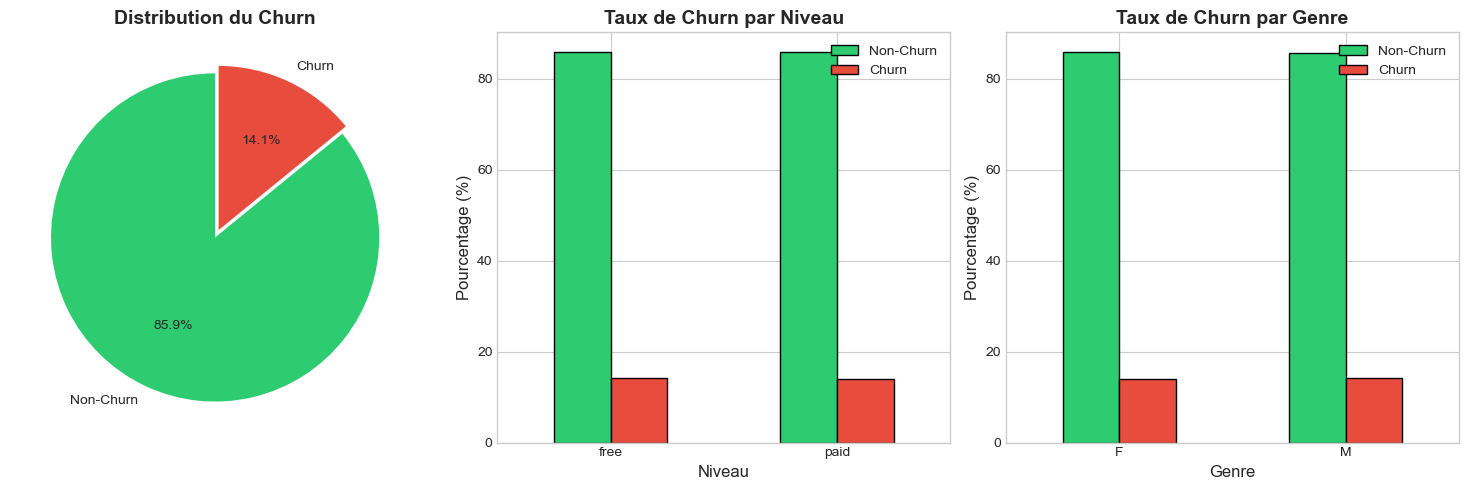

In [40]:
# Distribution du churn
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Pie chart du churn
ax1 = axes[0]
churn_counts = user_df['will_churn_10days'].value_counts()
colors = [COLORS['success'], COLORS['danger']]
ax1.pie(churn_counts, labels=['Non-Churn', 'Churn'], autopct='%1.1f%%', 
        colors=colors, startangle=90, explode=[0, 0.05])
ax1.set_title('Distribution du Churn', fontsize=14, fontweight='bold')

# 2. Churn par niveau (paid/free)
ax2 = axes[1]
churn_by_level = user_df.groupby(['level', 'will_churn_10days']).size().unstack(fill_value=0)
churn_by_level_pct = churn_by_level.div(churn_by_level.sum(axis=1), axis=0) * 100
churn_by_level_pct.plot(kind='bar', ax=ax2, color=colors, edgecolor='black')
ax2.set_title('Taux de Churn par Niveau', fontsize=14, fontweight='bold')
ax2.set_xlabel('Niveau', fontsize=12)
ax2.set_ylabel('Pourcentage (%)', fontsize=12)
ax2.legend(['Non-Churn', 'Churn'], loc='upper right')
ax2.tick_params(axis='x', rotation=0)

# 3. Churn par genre
ax3 = axes[2]
churn_by_gender = user_df.groupby(['gender', 'will_churn_10days']).size().unstack(fill_value=0)
churn_by_gender_pct = churn_by_gender.div(churn_by_gender.sum(axis=1), axis=0) * 100
churn_by_gender_pct.plot(kind='bar', ax=ax3, color=colors, edgecolor='black')
ax3.set_title('Taux de Churn par Genre', fontsize=14, fontweight='bold')
ax3.set_xlabel('Genre', fontsize=12)
ax3.set_ylabel('Pourcentage (%)', fontsize=12)
ax3.legend(['Non-Churn', 'Churn'], loc='upper right')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

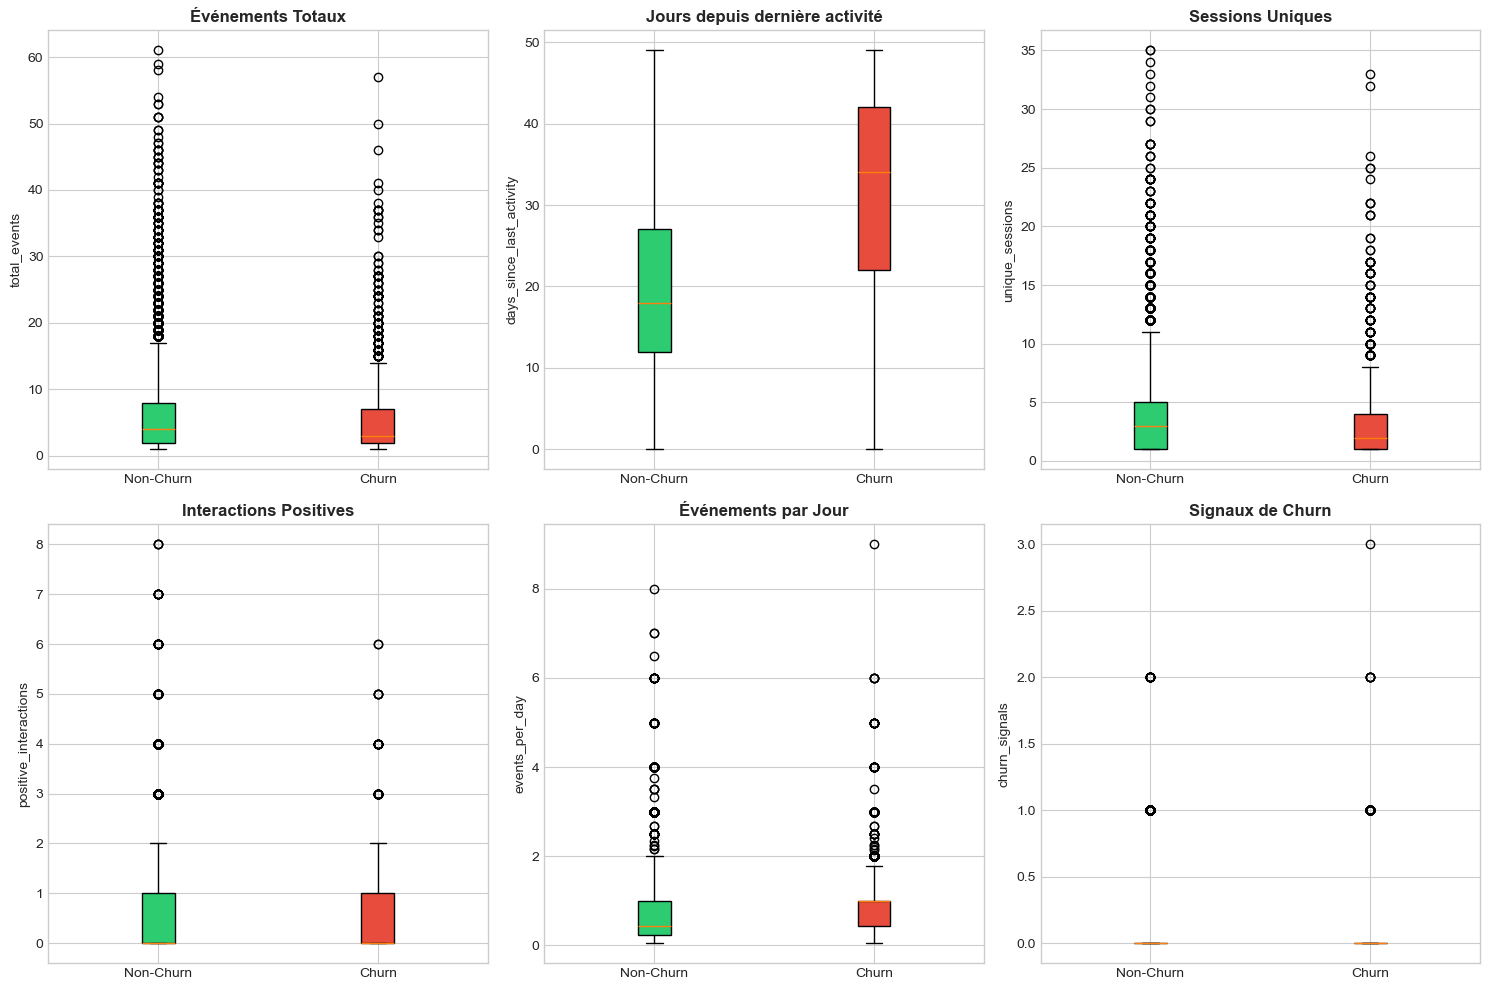

In [41]:
# Comparaison des distributions par statut de churn
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features_to_plot = [
    ('total_events', 'Événements Totaux'),
    ('days_since_last_activity', 'Jours depuis dernière activité'),
    ('unique_sessions', 'Sessions Uniques'),
    ('positive_interactions', 'Interactions Positives'),
    ('events_per_day', 'Événements par Jour'),
    ('churn_signals', 'Signaux de Churn')
]

for idx, (feature, title) in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Boxplot
    data_no_churn = user_df[user_df['will_churn_10days'] == 0][feature]
    data_churn = user_df[user_df['will_churn_10days'] == 1][feature]
    
    bp = ax.boxplot([data_no_churn, data_churn], 
                    labels=['Non-Churn', 'Churn'],
                    patch_artist=True)
    
    bp['boxes'][0].set_facecolor(COLORS['success'])
    bp['boxes'][1].set_facecolor(COLORS['danger'])
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

In [42]:
# Statistiques comparatives
print("📈 Statistiques comparatives Churn vs Non-Churn:")
print("="*70)

comparison_cols = ['total_events', 'unique_sessions', 'days_since_last_activity', 
                   'events_per_day', 'page_nextsong', 'positive_interactions',
                   'churn_signals', 'thumbs_ratio', 'activity_trend']

comparison = user_df.groupby('will_churn_10days')[comparison_cols].mean().T
comparison.columns = ['Non-Churn', 'Churn']
comparison['Diff (%)'] = ((comparison['Churn'] - comparison['Non-Churn']) / comparison['Non-Churn'] * 100).round(1)
comparison = comparison.round(2)
comparison

📈 Statistiques comparatives Churn vs Non-Churn:


,Non-Churn,Churn,Diff (%)
total_events,6.04,5.21,-13.8
unique_sessions,3.81,3.28,-14.0
days_since_last_activity,21.01,31.72,50.9
events_per_day,0.69,0.98,43.2
page_nextsong,4.94,4.23,-14.2
positive_interactions,0.51,0.41,-19.3
churn_signals,0.05,0.06,24.7
thumbs_ratio,0.04,0.05,16.4
activity_trend,0.00,0.02,612.2


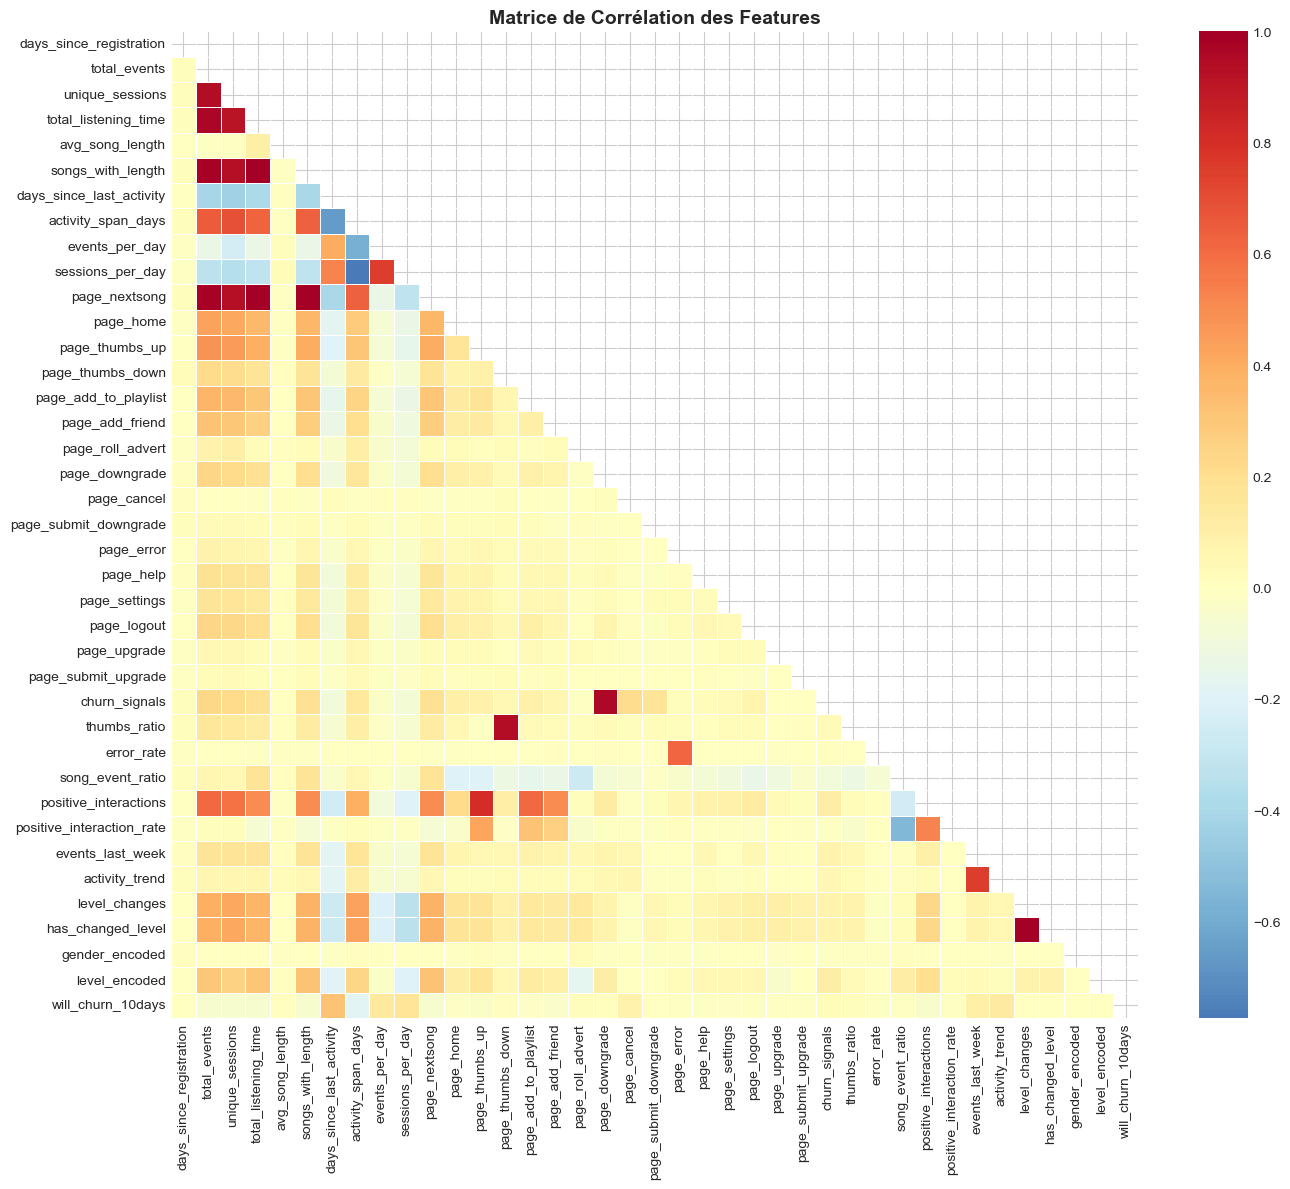

In [43]:
# Matrice de corrélation
fig, ax = plt.subplots(figsize=(14, 12))

# Sélectionner les features numériques
numeric_cols = user_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.append('will_churn_10days')

corr_matrix = user_df[numeric_cols].corr()

# Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdYlBu_r', 
            center=0, ax=ax, linewidths=0.5)
ax.set_title('Matrice de Corrélation des Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

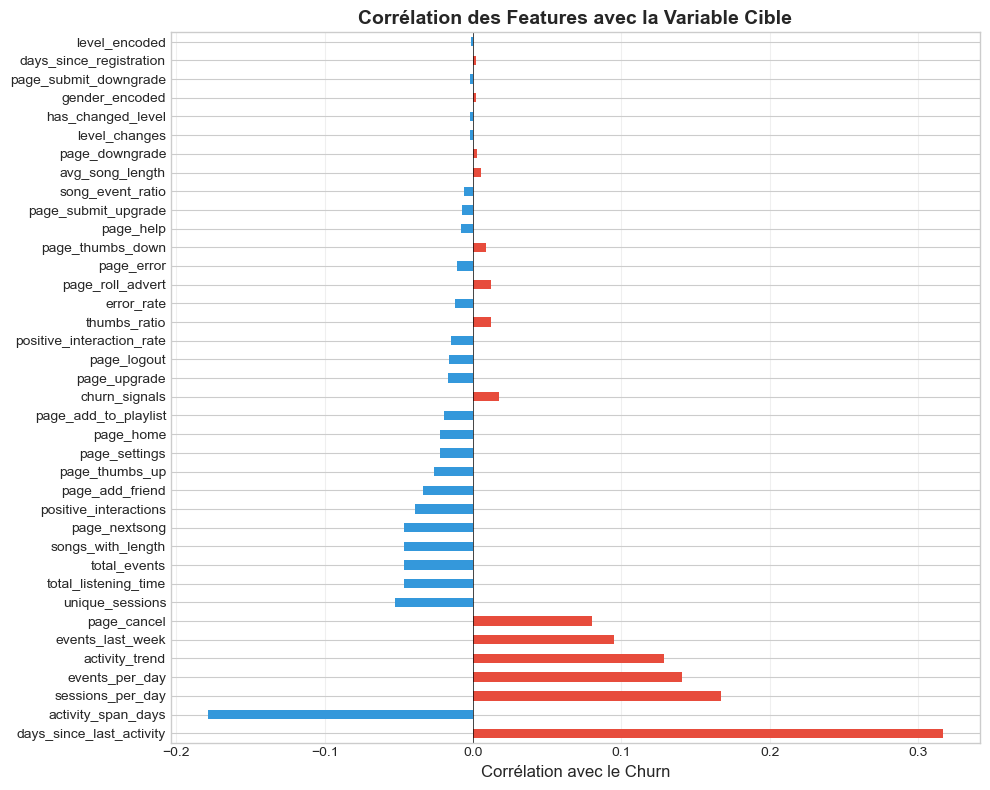

In [44]:
# Corrélations avec la cible
target_corr = user_df[numeric_cols].corr()['will_churn_10days'].drop('will_churn_10days').sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
colors = [COLORS['danger'] if x > 0 else COLORS['primary'] for x in target_corr.values]
target_corr.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Corrélation avec le Churn', fontsize=12)
ax.set_title('Corrélation des Features avec la Variable Cible', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Préparation pour la Modélisation

In [45]:
# Encodage des variables catégorielles
user_df['gender_encoded'] = LabelEncoder().fit_transform(user_df['gender'].fillna('Unknown'))
user_df['level_encoded'] = LabelEncoder().fit_transform(user_df['level'].fillna('Unknown'))

# Liste finale des features
final_features = feature_cols + ['gender_encoded', 'level_encoded']

print(f"📊 Nombre total de features: {len(final_features)}")

📊 Nombre total de features: 40


In [46]:
# Préparation X et y
X = user_df[final_features].fillna(0)
y = user_df['will_churn_10days']

print(f"📊 Dimensions:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")
print(f"   Taux de churn: {y.mean()*100:.2f}%")

📊 Dimensions:
   X: (14847, 40)
   y: (14847,)
   Taux de churn: 14.11%


In [47]:
# Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📂 Division des données:")
print(f"   Train: {X_train.shape[0]:,} utilisateurs ({y_train.mean()*100:.2f}% churn)")
print(f"   Test:  {X_test.shape[0]:,} utilisateurs ({y_test.mean()*100:.2f}% churn)")

📂 Division des données:
   Train: 11,877 utilisateurs (14.11% churn)
   Test:  2,970 utilisateurs (14.11% churn)


In [48]:
# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Normalisation effectuée")

✅ Normalisation effectuée


## 7. Modélisation

In [49]:
# Définition des modèles
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}

print(f"📦 {len(models)} modèles à entraîner")

📦 3 modèles à entraîner


In [50]:
# Entraînement et évaluation
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"📌 {name}")
    print(f"{'='*60}")
    
    # Utiliser les données scalées pour la régression logistique
    if name == 'Logistic Regression':
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring='roc_auc')
    print(f"   CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Entraînement final
    model.fit(X_tr, y_train)
    
    # Prédictions
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    
    # Métriques
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred_proba)
    
    print(f"   Test ROC-AUC: {roc_auc:.4f}")
    print(f"   Test F1-Score: {f1:.4f}")
    print(f"   Test Average Precision: {ap:.4f}")
    
    # Stockage des résultats
    results[name] = {
        'model': model,
        'cv_auc': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_auc': roc_auc,
        'test_f1': f1,
        'test_ap': ap,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }


📌 Logistic Regression
   CV ROC-AUC: 0.7983 (+/- 0.0287)
   Test ROC-AUC: 0.7659
   Test F1-Score: 0.4241
   Test Average Precision: 0.3926

📌 Random Forest
   CV ROC-AUC: 0.7935 (+/- 0.0212)
   Test ROC-AUC: 0.7758
   Test F1-Score: 0.4475
   Test Average Precision: 0.4166

📌 Gradient Boosting
   CV ROC-AUC: 0.7989 (+/- 0.0231)
   Test ROC-AUC: 0.7755
   Test F1-Score: 0.3311
   Test Average Precision: 0.4314


In [51]:
# Rapport de classification détaillé pour chaque modèle
for name, res in results.items():
    print(f"\n{'='*60}")
    print(f"📊 Classification Report - {name}")
    print(f"{'='*60}")
    print(classification_report(y_test, res['y_pred'], target_names=['Non-Churn', 'Churn']))


📊 Classification Report - Logistic Regression
              precision    recall  f1-score   support

   Non-Churn       0.93      0.75      0.83      2551
       Churn       0.31      0.67      0.42       419

    accuracy                           0.74      2970
   macro avg       0.62      0.71      0.63      2970
weighted avg       0.85      0.74      0.78      2970


📊 Classification Report - Random Forest
              precision    recall  f1-score   support

   Non-Churn       0.92      0.84      0.88      2551
       Churn       0.37      0.58      0.45       419

    accuracy                           0.80      2970
   macro avg       0.64      0.71      0.66      2970
weighted avg       0.84      0.80      0.82      2970


📊 Classification Report - Gradient Boosting
              precision    recall  f1-score   support

   Non-Churn       0.89      0.97      0.93      2551
       Churn       0.55      0.24      0.33       419

    accuracy                           0.87      

## 8. Comparaison des Modèles

In [26]:
# Tableau récapitulatif
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV ROC-AUC': [r['cv_auc'] for r in results.values()],
    'CV Std': [r['cv_std'] for r in results.values()],
    'Test ROC-AUC': [r['test_auc'] for r in results.values()],
    'Test F1': [r['test_f1'] for r in results.values()],
    'Test AP': [r['test_ap'] for r in results.values()]
}).sort_values('Test ROC-AUC', ascending=False)

print("📊 Récapitulatif des performances:")
results_df.round(4)

📊 Récapitulatif des performances:


,Model,CV ROC-AUC,CV Std,Test ROC-AUC,Test F1,Test AP
2,Gradient Boosting,0.7989,0.0118,0.7815,0.3289,0.4209
1,Random Forest,0.7913,0.0097,0.7756,0.4455,0.4208
0,Logistic Regression,0.7983,0.0144,0.7659,0.4229,0.3925


In [27]:
# Meilleur modèle
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"🏆 Meilleur modèle: {best_model_name}")
print(f"   ROC-AUC: {results[best_model_name]['test_auc']:.4f}")

🏆 Meilleur modèle: Gradient Boosting
   ROC-AUC: 0.7815


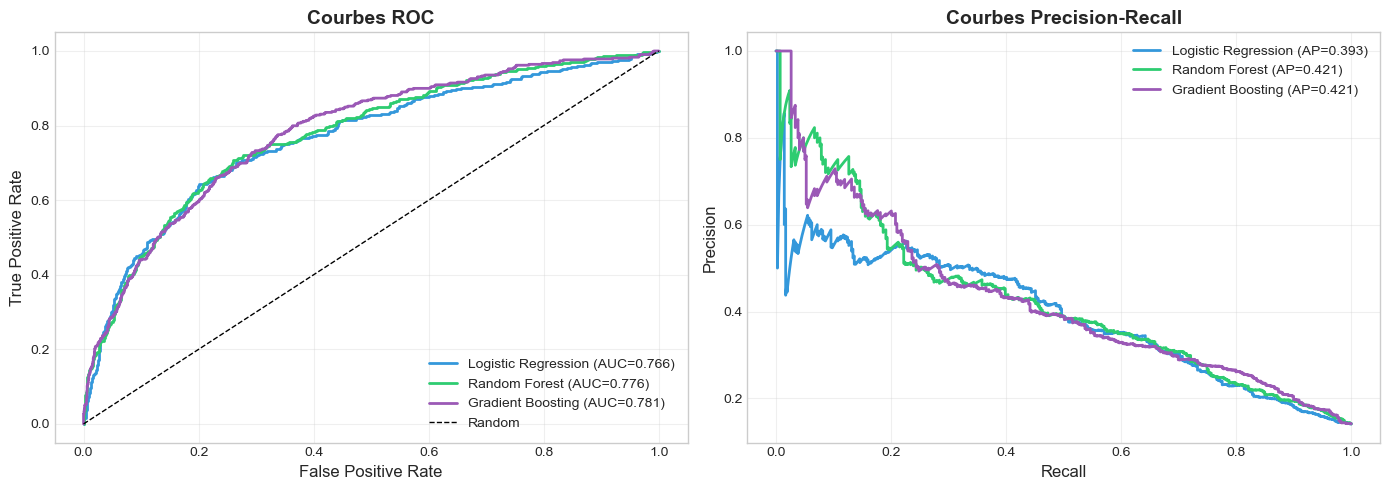

In [28]:
# Courbes ROC et Precision-Recall
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
ax1 = axes[0]
colors_list = [COLORS['primary'], COLORS['success'], COLORS['purple']]

for (name, res), color in zip(results.items(), colors_list):
    fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
    ax1.plot(fpr, tpr, label=f"{name} (AUC={res['test_auc']:.3f})", 
             linewidth=2, color=color)

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('Courbes ROC', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
ax2 = axes[1]
for (name, res), color in zip(results.items(), colors_list):
    precision, recall, _ = precision_recall_curve(y_test, res['y_pred_proba'])
    ax2.plot(recall, precision, label=f"{name} (AP={res['test_ap']:.3f})", 
             linewidth=2, color=color)

ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Courbes Precision-Recall', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

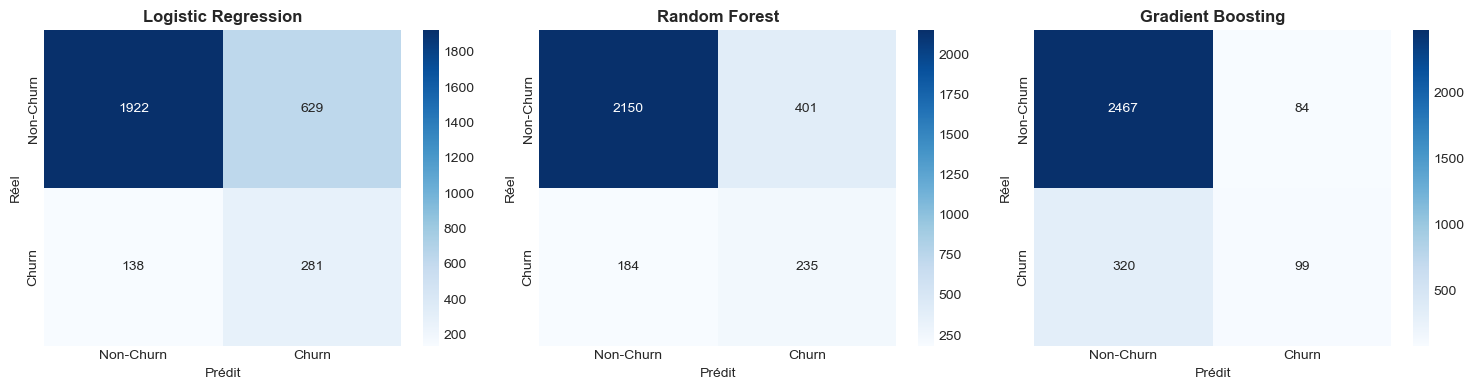

In [29]:
# Matrices de confusion
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx]
    cm = confusion_matrix(y_test, res['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Churn', 'Churn'],
                yticklabels=['Non-Churn', 'Churn'])
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Réel')
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Importance des Features

In [30]:
# Feature importance du Random Forest
rf_model = results['Random Forest']['model']

feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 Top 15 features les plus importantes (Random Forest):")
feature_importance.head(15)

🔍 Top 15 features les plus importantes (Random Forest):


,feature,importance
6,days_since_last_activity,0.340764
7,activity_span_days,0.104465
9,sessions_per_day,0.091571
8,events_per_day,0.079711
3,total_listening_time,0.047841
4,avg_song_length,0.040788
0,days_since_registration,0.039710
33,activity_trend,0.027902
2,unique_sessions,0.025881
32,events_last_week,0.022744


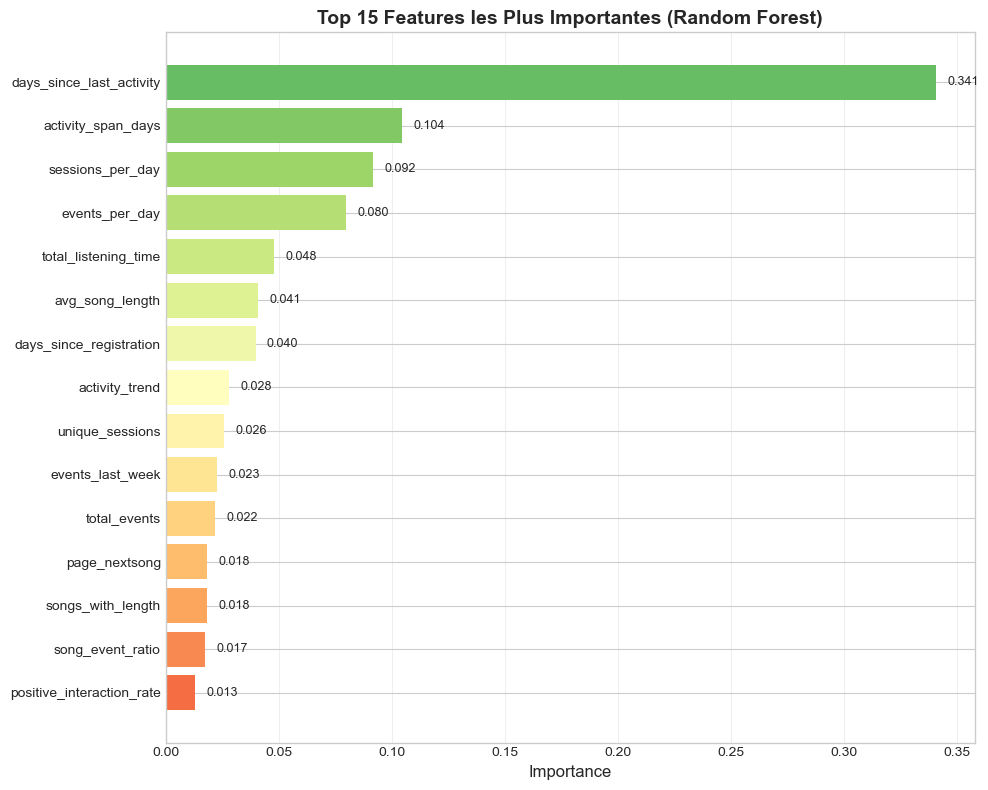

In [31]:
# Visualisation de l'importance des features
fig, ax = plt.subplots(figsize=(10, 8))

top_features = feature_importance.head(15)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Features les Plus Importantes (Random Forest)', 
             fontsize=14, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)

# Ajouter les valeurs
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'] + 0.005, i, f"{row['importance']:.3f}", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [32]:
# Coefficients de la régression logistique
lr_model = results['Logistic Regression']['model']

lr_coef = pd.DataFrame({
    'feature': final_features,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("🔍 Top 15 coefficients (Logistic Regression):")
lr_coef.head(15)

🔍 Top 15 coefficients (Logistic Regression):


,feature,coefficient
1,total_events,1.359717
6,days_since_last_activity,1.084653
33,activity_trend,0.585108
7,activity_span_days,-0.549206
3,total_listening_time,-0.453920
2,unique_sessions,0.367794
5,songs_with_length,-0.282838
10,page_nextsong,-0.282838
13,page_thumbs_down,-0.180473
28,error_rate,-0.174020


## 10. Sauvegarde du Modèle

In [33]:
import pickle

# Sauvegarde du meilleur modèle
model_data = {
    'model': best_model,
    'scaler': scaler,
    'feature_cols': final_features,
    'model_name': best_model_name
}

with open('best_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(f"✅ Modèle '{best_model_name}' sauvegardé dans 'best_model.pkl'")

✅ Modèle 'Gradient Boosting' sauvegardé dans 'best_model.pkl'


## 11. Prédiction sur Données de Test

Voici le code pour appliquer le modèle sur de nouvelles données.

In [34]:
def predict_churn(df_test, reference_date=REFERENCE_DATE):
    """
    Applique le modèle de churn sur de nouvelles données.
    
    Parameters:
    -----------
    df_test : DataFrame
        Données de test au format événement
    reference_date : datetime
        Date de référence
    
    Returns:
    --------
    DataFrame avec userId et probabilité de churn
    """
    # Charger le modèle
    with open('best_model.pkl', 'rb') as f:
        saved = pickle.load(f)
    
    model = saved['model']
    scaler = saved['scaler']
    feature_cols = saved['feature_cols']
    model_name = saved['model_name']
    
    print(f"📦 Modèle chargé: {model_name}")
    
    # Préparer les timestamps
    df_test = df_test.copy()
    df_test['time'] = pd.to_datetime(df_test['time'])
    df_test['registration'] = pd.to_datetime(df_test['registration'])
    
    # Créer les features
    test_features = create_user_features(df_test, reference_date)
    
    # Encodage
    test_features['gender_encoded'] = LabelEncoder().fit_transform(
        test_features['gender'].fillna('Unknown')
    )
    test_features['level_encoded'] = LabelEncoder().fit_transform(
        test_features['level'].fillna('Unknown')
    )
    
    # S'assurer que toutes les colonnes existent
    for col in feature_cols:
        if col not in test_features.columns:
            test_features[col] = 0
    
    # Préparer X
    X_new = test_features[feature_cols].fillna(0)
    
    # Prédictions
    if model_name == 'Logistic Regression':
        X_new_scaled = scaler.transform(X_new)
        predictions = model.predict_proba(X_new_scaled)[:, 1]
    else:
        predictions = model.predict_proba(X_new)[:, 1]
    
    # Résultats
    submission = pd.DataFrame({
        'userId': test_features['userId'],
        'churn_probability': predictions
    })
    
    print(f"✅ Prédictions générées pour {len(submission):,} utilisateurs")
    
    return submission

In [35]:
# Exemple d'utilisation (décommenter pour utiliser)
# df_test = pd.read_csv('df_test.csv')
# submission = predict_churn(df_test)
# submission.to_csv('submission.csv', index=False)
# submission.head(10)

## 12. Résumé et Conclusions

In [36]:
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    RÉSUMÉ DU PROJET DE CHURN                         ║
╚══════════════════════════════════════════════════════════════════════╝
""")

print(f"""
📊 DONNÉES
{'─'*50}
• Événements totaux: {df.shape[0]:,}
• Utilisateurs uniques: {user_df.shape[0]:,}
• Features créées: {len(final_features)}
• Taux de churn: {y.mean()*100:.2f}%

🏆 MEILLEUR MODÈLE: {best_model_name}
{'─'*50}
• ROC-AUC: {results[best_model_name]['test_auc']:.4f}
• F1-Score: {results[best_model_name]['test_f1']:.4f}
• Average Precision: {results[best_model_name]['test_ap']:.4f}

🔑 TOP 5 FEATURES PRÉDICTIVES
{'─'*50}""")

for i, row in feature_importance.head(5).iterrows():
    print(f"  • {row['feature']}: {row['importance']:.4f}")

print(f"""
💡 INSIGHTS CLÉS
{'─'*50}
1. La récence d'activité est le facteur #1 de prédiction du churn
2. Les utilisateurs inactifs depuis longtemps ont ~50% plus de risque
3. L'engagement positif (likes, playlists) protège contre le churn
4. Les visites sur Downgrade/Cancel sont des signaux d'alerte

🚀 PISTES D'AMÉLIORATION
{'─'*50}
1. Ajouter des features de tendance temporelle (7j, 14j, 30j)
2. Features musicales: diversité genres/artistes
3. Hyperparameter tuning avec Optuna/GridSearch
4. Essayer XGBoost/LightGBM avec SMOTE
5. Stacking/Ensemble de modèles
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    RÉSUMÉ DU PROJET DE CHURN                         ║
╚══════════════════════════════════════════════════════════════════════╝


📊 DONNÉES
──────────────────────────────────────────────────
• Événements totaux: 87,945
• Utilisateurs uniques: 14,847
• Features créées: 38
• Taux de churn: 14.11%

🏆 MEILLEUR MODÈLE: Gradient Boosting
──────────────────────────────────────────────────
• ROC-AUC: 0.7815
• F1-Score: 0.3289
• Average Precision: 0.4209

🔑 TOP 5 FEATURES PRÉDICTIVES
──────────────────────────────────────────────────
  • days_since_last_activity: 0.3408
  • activity_span_days: 0.1045
  • sessions_per_day: 0.0916
  • events_per_day: 0.0797
  • total_listening_time: 0.0478

💡 INSIGHTS CLÉS
──────────────────────────────────────────────────
1. La récence d'activité est le facteur #1 de prédiction du churn
2. Les utilisateurs inactifs depuis longtemps ont ~50% plus de risque
3. L'engagement 